In [117]:


#!jupyter nbconvert --to html  IGPL.ipynb  --no-input --output-dir=./results/
# --to pdf, html, latex 



In [118]:


import json
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 15)

keep_metrics = ['HV', 'spread', 'unfr','time','nds_update_time']

datasets_names = ['p1', 'p2', 's1', 's2', 's3', 's4']  
algorithms = ['geneticnds', 'umda', 'pbil','mimic', 'GRASP'] 
time_limit = 100000 # 150 (100000 is no limit)
use_best_config_in_all_datasets = True # True (original) uses the config which worked best among all datasets. False uses the best config for each dataset (and thus time_limit is respected)
values_sss = [True] # si es con los dos: [False, True]


files_container = '../output/files_list_allGRASP_GRASP-geneticnds-umda-pbil-mimic'
#'../output/files_list_allGRASP_GRASP-nsgaii-umda-mimic'



## 1 Datasets

In [119]:
import sys  
sys.path.insert(0, '../datasets')
from Dataset import Dataset

ds_summary = pd.DataFrame(columns=['Dataset', '#Stakeholders', '#PBI'])

for name in datasets_names:
    
    ds = Dataset(source_file='..\datasets\\'+ name+ '.json')
    n_pbis = ds.num_pbis
    n_stakeholders = len(ds.stakeholders_importances)

        
    new_row = {'Dataset': name, '#Stakeholders': n_stakeholders, '#PBI': n_pbis}
    ds_summary = ds_summary.append(new_row, ignore_index=True)

def row_color(val):
    
    if val < 2: color = 'background-color: yellow'

    return color


pd.set_option('display.float_format', '{:.3f}'.format)
display(ds_summary)




,Dataset,#Stakeholders,#PBI
0,p1,5,20
1,p2,5,100
2,s1,15,40
3,s2,50,80
4,s3,100,140
5,s4,150,200


In [120]:
import math

def getdf_with_params_and_metrics(files, keep_parameters):

    parameters_dictios_list = []
    metrics_dictios_list = []
    file_list = []
    
    
    for file in files:
        with open(file, 'r') as f:
            dictio = json.load(f)
            mean_time =  np.mean(dictio['metrics']['time']) 
            if mean_time < time_limit:
                parameters_dictios_list.append(dictio['parameters'])
                metrics_dictios_list.append(dictio['metrics'])
                file_list.append(file)
        
            

    parameters_df= pd.DataFrame(parameters_dictios_list)
    parameters_df = parameters_df[['dataset'] + keep_parameters]

    metrics_df = pd.DataFrame(metrics_dictios_list)
    
    
    metrics_df = metrics_df[keep_metrics]
    
    #lists = metrics_df['gdplus']
    #for l in lists:
     #   for x in l:
      #      if isinstance(x, str): print(x, l)

    
    for column in keep_metrics: #we have several runs for each metric (list of values in each cell), so compute mean
        #metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist())
        metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist()).mean(axis=1)
    #display(metrics_df)
    combined_df=parameters_df.join(metrics_df)
    combined_df['file']=file_list

    return combined_df

In [121]:
import pandas as pd
import re

# Counts the number of wins (HV by default) for each configuration in data_df of the given hyperparameters.
# Each win is computed from results for a dataset
# returns:
#    dictionary with the, most frequently, best configuration. if ties, then first occurrence is returned
#    dictionary with the count of configuration which were the best at leats once
#    number of datasets    
# 
def get_best_configuration(data_df, hyperparameters, metric: str = 'HV') -> dict:
    
    dataset_groups = data_df.groupby(['dataset'])
    best_configs_counts = {}


    for group in dataset_groups: # find best hyperparameters config
        #print(group)
        group_df = pd.DataFrame(group[1])
        max_index = group_df[metric].idxmax()
        best_config = (group[1][hyperparameters]).loc[max_index]
        dataset_name = (group[1]['dataset']).loc[max_index] #any row
        file_name = (group[1]['file']).loc[max_index] 
        time = round((group[1]['time']).loc[max_index],2)
        
        key = best_config.to_string()
        besthv = round(group_df[metric].loc[max_index], 4)
        if key in best_configs_counts.keys():
            (count, list_datasets, list_hv, list_time, list_files) = best_configs_counts[key]
            list_datasets.extend([dataset_name])
            list_hv.extend([besthv])
            list_time.extend([time])
            list_files.extend([file_name])
           
            best_configs_counts[key]= (count + 1, list_datasets, list_hv, list_time, list_files)
        else:
            best_configs_counts[key] = (1, [dataset_name], [besthv], [time], [file_name])

           
    
    #print(best_configs_counts)
   # print(len(best_configs_counts))
    #print(best_configs_counts)
    v = list(best_configs_counts.values())
    k = list(best_configs_counts.keys())
    best_config = k[v.index(max(v))]

    #convert string of best config to dictionary 
    best_config = re.sub(' +',' ',best_config)
    best_config = best_config.replace(' ',':')
    best_config = best_config.replace('\n',',')
    best = dict((x.strip(), y.strip())
             for x, y in (element.split(':') 
             for element in best_config.split(',')))
    return best, best_configs_counts, len(dataset_groups)
    
        

In [122]:
# convert dictionary counts of each best configuration to dataframe
def dictionary_keystring_to_dataframe(keep_parameters, best_counts):
    table_df = pd.DataFrame(columns=keep_parameters+['datasets'])
    for k in best_counts.keys():
        #print(f"{k} \n\t\t---> was the best config in: {best_counts[k]} datasets")
        row_dict = dict()
        for col in keep_parameters:
            start=k.index(col+' ')
            try: 
                end=k.index("\n", start)
            except: end = len(k)
            line = k[start:end]
            key = line[0:line.index(' ')]
            value = line[line.rfind(' ')+1:len(line)]
            row_dict[key]=value
        (counts, datasets_names, HVs, times, file_example) = best_counts[k]
        row_dict['datasets'] = datasets_names
        row_dict['HV'] = HVs
        row_dict['time'] = times
        row_dict['wins'] = int(counts)
        row_dict['file'] = file_example
        table_df = table_df.append(row_dict, ignore_index=True)
    return table_df

In [123]:
def print_hyperparams_values(df, hyperparmeters, algorithm):
    print(f"These are the different values used to set hyperparameters in {algorithm}, for each dataset:")
    mult = 1
    for hp in hyperparmeters:
        values = df[hp].unique()
        mult = mult * len(values)
        print(f"{hp}: {values}")
    print(f"In total, {mult} configuration per dataset.")

In [124]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files


In [125]:
def get_files_for_dataset(dataset_name):
    files = []
    with open(files_container, 'r') as f:
        for line in f:
            # todo: al haber metido en files_list los geneticos, resulta que tienen "p1" en todos los nombres por 'flip1bit', y elitismnds30 con s3.
            temp_line = line.replace("flip1bit", '')
            temp_line = temp_line.replace("elitismnds30", '')
            if dataset_name in temp_line: 
                files.append('../'+str(line.replace('\n','')))
    return files

## 2 Search of the best hyperparameters configuration for each algorithm, given SSS_per_iteration={False,True}

### 2.1 Best configuration for: GRASP

In [126]:
#filest_list_GRASP contains all output files from the GRASP algorithm. Goal is to find the best hyperparameters configuration.
# 
algorithm =  'GRASP'
if('GRASP' in files_container):

    keep_parameters = ['solutions_per_iteration', 'iterations', 'init_type', 'local_search_type', 'path_relinking_mode','sss_per_iteration']
    

    files = []
    with open(files_container, 'r') as f:
        for line in f:
             if algorithm in line:
                files.append('../'+str(line.replace('\n','')))

    
    df_grasp = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
    df_grasp = df_grasp[df_grasp.dataset.isin(datasets_names)]
    
    print_hyperparams_values(df_grasp, keep_parameters, "GRASP")

    #display(df_grasp)
    best_for_grasp_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
    
    for it in np.arange(0,len(values_sss)):

        df_filtered = df_grasp.loc[df_grasp['sss_per_iteration'] == values_sss[it]]

        best_config_grasp, best_counts,  ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
     
        best_for_grasp_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)

        print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
            "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
            "can be interpreted as 'minimum configuration to converge'.")


        display(best_for_grasp_df[it].drop(['file'], axis=1, inplace=False))


        print(f"\nBest hyperparameter configuration for GRASP when sss_per_iteration={values_sss[it]}:")
        for param in best_config_grasp:
            print(f"{param}:{best_config_grasp[param]}")



    




These are the different values used to set hyperparameters in GRASP, for each dataset:
solutions_per_iteration: [700]
iterations: [400]
init_type: ['stochastically']
local_search_type: ['None' 'best_first_neighbor_random' 'best_first_neighbor_sorted_score'
 'best_first_neighbor_sorted_score_r'
 'best_first_neighbor_random_domination'
 'best_first_neighbor_sorted_domination']
path_relinking_mode: [None 'after_local']
sss_per_iteration: [ True]
In total, 12 configuration per dataset.

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,solutions_per_iteration,iterations,init_type,local_search_type,path_relinking_mode,sss_per_iteration,datasets,HV,time,wins
0,700,400,stochastically,None,None,True,[p1],[0.9931],[359.0],1.000
1,700,400,stochastically,None,after_local,True,"[p2, s4]","[0.8885, 0.8448]","[8666.29, 32381.13]",2.000
2,700,400,stochastically,best_first_neighbor_random_domination,after_local,True,"[s1, s2, s3]","[0.8868, 0.8202, 0.8711]","[2258.82, 6591.51, 16413.31]",3.000



Best hyperparameter configuration for GRASP when sss_per_iteration=True:
solutions_per_iteration:700
iterations:400
init_type:stochastically
local_search_type:best_first_neighbor_random_domination
path_relinking_mode:after_local
sss_per_iteration:True


### 2.2 Best configuration for: GeneticNDS

In [127]:
# files_container contains all output files from the geneticNDS algorithm. Goal is to find the best hyperparameters configuration.
algorithm =  'geneticNDS'
keep_parameters = ['population_length', 'max_generations', 'selection_candidates', 'crossover_prob', 'mutation_prob', 'mutation', 'replacement','sss_per_iteration']
#files_container = '../output/filest_list_geneticnds'



files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_genetic = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_genetic = df_genetic[df_genetic.dataset.isin(datasets_names)]
print_hyperparams_values(df_genetic, keep_parameters, "GeneticNDS")

#display(df_genetic)
best_for_geneticnds_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True

for it in np.arange(0,len(values_sss)):

    df_filtered = df_genetic.loc[df_genetic['sss_per_iteration'] == values_sss[it]]

    best_config_geneticNDS, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')

    best_for_geneticnds_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")

    display(best_for_geneticnds_df[it].drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for GeneticNDS is:")
    for param in best_config_geneticNDS:
        print(f"{param}:{best_config_geneticNDS[param]}")


    #print(best_for_geneticnds_df[it].drop(['file','selection_candidates','crossover_prob', 'mutation', 'replacement'], axis=1, inplace=False).to_latex(index=False))
        



These are the different values used to set hyperparameters in GeneticNDS, for each dataset:
population_length: [700]
max_generations: [400]
selection_candidates: [2]
crossover_prob: [0.8]
mutation_prob: [0.1 0.3]
mutation: ['flip1bit']
replacement: ['elitismnds']
sss_per_iteration: [ True]
In total, 2 configuration per dataset.

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_candidates,crossover_prob,mutation_prob,mutation,replacement,sss_per_iteration,datasets,HV,time,wins
0,700,400,2,0.8,0.3,flip1bit,elitismnds,True,"[p1, p2, s1, s2, s3, s4]","[0.9557, 0.7109, 0.7757, 0.6803, 0.6793, 0.6436]","[257.37, 348.7, 319.06, 265.82, 397.28, 320.88]",6.000



Best hyperparameter configuration for GeneticNDS is:
population_length:700
max_generations:400
selection_candidates:2
crossover_prob:0.8
mutation_prob:0.3
mutation:flip1bit
replacement:elitismnds
sss_per_iteration:True


### 2.3 Best configuration for: UMDA



In [128]:
# Liles_container' contains all output files from the UMDA algorithm. Goal is to find the best hyperparameters configuration.
algorithm = 'umda'
keep_parameters = ['population_length', 'max_generations', 'selection_scheme', 'replacement_scheme','sss_per_iteration']

#files_container = '../output/filest_list_umda'

files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_umda = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_umda = df_umda[df_umda.dataset.isin(datasets_names)]
print_hyperparams_values(df_umda, keep_parameters, "UMDA")
#display(df_umda)

best_for_umda_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True

for it in np.arange(0,len(values_sss)):

    df_filtered = df_umda.loc[df_umda['sss_per_iteration'] == values_sss[it]]
    best_config_umda, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
    best_for_umda_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")


    display(best_for_umda_df[it].drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for UMDA when sss_per_iteration={values_sss[it]}:")
    for param in best_config_umda:
        print(f"{param}:{best_config_umda[param]}")


    #print(best_for_umda_df[it].drop(['file', 'replacement_scheme','selection_scheme'], axis=1, inplace=False).to_latex(index=False))

These are the different values used to set hyperparameters in UMDA, for each dataset:
population_length: [700]
max_generations: [400]
selection_scheme: ['nds']
replacement_scheme: ['elitism']
sss_per_iteration: [ True]
In total, 1 configuration per dataset.

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_scheme,replacement_scheme,sss_per_iteration,datasets,HV,time,wins
0,700,400,nds,elitism,True,"[p1, p2, s1, s2, s3, s4]","[0.9792, 0.8129, 0.8516, 0.7748, 0.7837, 0.7573]","[446.91, 1055.57, 824.67, 1271.43, 1870.11, 19...",6.000



Best hyperparameter configuration for UMDA when sss_per_iteration=True:
population_length:700
max_generations:400
selection_scheme:nds
replacement_scheme:elitism
sss_per_iteration:True


### 2.4 Best configuration for: PBIL

In [129]:
algorithm = 'pbil'
keep_parameters = ['population_length', 'max_generations','max_evaluations', 'learning_rate', 'mutation_prob','mutation_shift','sss_per_iteration']

#files_container = '../output/filest_list_pbil'


files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_pbil = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_pbil = df_pbil[df_pbil.dataset.isin(datasets_names)]
print_hyperparams_values(df_pbil, keep_parameters, "PBIL")
#display(df_pbil)
best_for_pbil_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True

for it in np.arange(0,len(values_sss)):

    df_filtered = df_pbil.loc[df_pbil['sss_per_iteration'] == values_sss[it]]
    best_config_pbil, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
    best_for_pbil_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")
    display(best_for_pbil_df[it].drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for PBIL is:")
    for param in best_config_pbil:
        print(f"{param}:{best_config_pbil[param]}")

    #print(best_for_pbil_df[it].drop(['file', 'learning_rate','mutation_prob', 'max_evaluations',
    #'mutation_shift'], axis=1, inplace=False).to_latex(index=False))


These are the different values used to set hyperparameters in PBIL, for each dataset:
population_length: [700]
max_generations: [400]
max_evaluations: [0]
learning_rate: [0.1]
mutation_prob: [0.1]
mutation_shift: [0.1]
sss_per_iteration: [ True]
In total, 1 configuration per dataset.

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,learning_rate,mutation_prob,mutation_shift,sss_per_iteration,datasets,HV,time,wins
0,700,400,0,0.1,0.1,0.1,True,"[p1, p2, s1, s2, s3, s4]","[0.9917, 0.6815, 0.8356, 0.6664, 0.6093, 0.5472]","[170.22, 143.0, 178.79, 194.48, 141.96, 151.48]",6.000



Best hyperparameter configuration for PBIL is:
population_length:700
max_generations:400
max_evaluations:0
learning_rate:0.1
mutation_prob:0.1
mutation_shift:0.1
sss_per_iteration:True


### 2.5 Best configuration for: MIMIC

In [130]:
if('mimic' in files_container):

    algorithm = 'mimic'
    keep_parameters = ['population_length', 'max_generations','max_evaluations', 'selection_scheme', 'selected_individuals','sss_per_iteration']




    files = []
    with open(files_container, 'r') as f:
        for line in f:
            if algorithm in line:
                files.append('../'+str(line.replace('\n','')))

    df_mimic = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
    df_mimic = df_mimic[df_mimic.dataset.isin(datasets_names)]
    print_hyperparams_values(df_mimic, keep_parameters, "MIMIC")
    #display(df_mimic)
    best_for_mimic_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
    
    for it in np.arange(0,len(values_sss)):

        df_filtered = df_mimic.loc[df_mimic['sss_per_iteration'] == values_sss[it]]
        best_config_mimic, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
        best_for_mimic_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


        print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
            "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
            "can be interpreted as 'minimum configuration to converge'.")
        display(best_for_mimic_df[it].drop(['file'], axis=1, inplace=False))

        print(f"\nBest hyperparameter configuration for MIMIC is:")
        for param in best_config_mimic:
            print(f"{param}:{best_config_mimic[param]}")

       



These are the different values used to set hyperparameters in MIMIC, for each dataset:
population_length: [700]
max_generations: [400]
max_evaluations: [0]
selection_scheme: ['nds']
selected_individuals: [50]
sss_per_iteration: [ True]
In total, 1 configuration per dataset.

Counts of best configurations found in 6 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,selection_scheme,selected_individuals,sss_per_iteration,datasets,HV,time,wins
0,700,400,0,nds,50,True,"[p1, p2, s1, s2, s3, s4]","[0.9931, 0.8532, 0.8787, 0.7933, 0.8173, 0.7783]","[525.88, 2621.39, 1205.68, 2672.43, 3004.21, 1...",6.000



Best hyperparameter configuration for MIMIC is:
population_length:700
max_generations:400
max_evaluations:0
selection_scheme:nds
selected_individuals:50
sss_per_iteration:True


### 2.6 Best configuration for: nsgaii


In [131]:

if('nsgaii' in files_container):
    algorithm =  'nsgaii'
    keep_parameters = ['population_length', 'max_generations', 'selection_candidates', 'crossover_prob', 'mutation_prob', 'mutation', 'replacement','sss_per_iteration']


    files = []
    with open(files_container, 'r') as f:
        for line in f:
            if algorithm in line:
                files.append('../'+str(line.replace('\n','')))


    df_nsgaii = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
    df_nsgaii = df_nsgaii[df_nsgaii.dataset.isin(datasets_names)]
    print_hyperparams_values(df_nsgaii, keep_parameters, "NSGA-II")

    #display(df_genetic)
    best_for_nsgaii_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True

    #for it in np.arange(0,len(values_sss)):

    df_filtered = df_nsgaii.loc[df_nsgaii['sss_per_iteration'] == False]

    best_config_nsgaii, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')

    best_for_nsgaii_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")

    display(best_for_nsgaii_df[it].drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for NSGA-II is:")
    for param in best_config_nsgaii:
        print(f"{param}:{best_config_nsgaii[param]}")


        #print(best_for_nsgaii_df[it].drop(['file','selection_candidates','crossover_prob', 'mutation', 'replacement'], axis=1, inplace=False).to_latex(index=False))
            



## 3 Plots of algorithms' NDS with their best configuration

In [132]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files
    
    


In [133]:

def get_files_list_with_best_configuration_per_dataset(alg_name, sss_per_it=False):
    it = values_sss.index(sss_per_it)
    #it = 1 if sss_per_it==True else it
    

    if alg_name=='GRASP':
        df_with_bests = best_for_grasp_df[it]
    if alg_name=='umda':
        df_with_bests = best_for_umda_df[it]
    if alg_name=='pbil':
        df_with_bests = best_for_pbil_df[it]
    if alg_name=='geneticNDS':
        df_with_bests = best_for_geneticnds_df[it]
    if alg_name=='mimic':
        df_with_bests = best_for_mimic_df[it]
    if alg_name=='nsgaii':
        df_with_bests = best_for_nsgaii_df[0] #not done with SSS per it

    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_names:
        try:
            best_conf_row = df_with_bests.loc[df_with_bests['datasets'].apply(lambda x: dataset in x)].iloc[0]
            position = best_conf_row['datasets'].index(dataset)
            file = best_conf_row.file[position]
            algorithm_files.extend([file])
        except: print(f"not best file yet for {dataset} for algorithm {alg_name}")
    
    return algorithm_files
    


In [134]:
import matplotlib as plt
def get_order_xy_points(solutions):
    x = [item[0] for item in solutions]
    y = [1-item[1] for item in solutions] #revert satisfaction. 0,0 is best point
        
    tuples = list(zip(x,y))
    tuples.sort()
    x = list(zip(*tuples))[0]
    y = list(zip(*tuples))[1]
    return x,y
    
    

In [135]:
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

    
def plot_algorithms_nds(use_best_global_config=True, sss_per_iteration=False):

    index = values_sss.index(sss_per_iteration)
    #index = 0
    #if sss_per_iteration:
    #    index = 1
    files_all_algorithms =[]
    if use_best_global_config:
        files_all_algorithms =[ #WARNING!! get_files... in the same order than algorithms global variable, commonly: 'GRASP', 'geneticNDS', 'umda', 'pbil',  'mimic', 'nsgaii'
           
            #get_files_list_with_best_configuration(best_for_nsgaii_df[0],datasets_names), #nsga does not use SSS per iteration ever
            get_files_list_with_best_configuration(best_for_geneticnds_df[index],datasets_names),
            get_files_list_with_best_configuration(best_for_umda_df[index],datasets_names),
            get_files_list_with_best_configuration(best_for_pbil_df[index],datasets_names),
            get_files_list_with_best_configuration(best_for_mimic_df[index],datasets_names),
            get_files_list_with_best_configuration(best_for_grasp_df[index],datasets_names), # [0] is sss_per_it =false
            
            
        ]
    else: #use best config for each dataset in each algorithm
        for alg in algorithms:
            files_all_algorithms = files_all_algorithms + [get_files_list_with_best_configuration_per_dataset(alg_name=alg, sss_per_it=sss_per_iteration)]
            

    wins_counts = {}
    wins_counts_unfr = {}
    wins_counts_gd = {}
    wins_counts_spread = {}
    wins_datasets = {}
    for alg in algorithms:
        wins_counts[alg] = 0
        wins_datasets[alg] = []
        wins_counts_unfr[alg] = 0
        wins_counts_gd[alg] = 0
        wins_counts_spread[alg] = 0


    # print 30 (or the number of execution) paretos of each dataset
    # (maybe one plot per dataset, and all differente algorithms in each plot)

    #latex_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)","|NDS|"])
    latex_df = pd.DataFrame(columns=["Method","HV","UNFR","spread","time(s)","|NDS|"])
    for i in range(0,len(datasets_names)):
        fig = plt.figure(figsize=(15,5)) #20,5 when plotting also ax2 with table
        #ax =fig.add_axes([0,0,1,1])
        ax = fig.add_subplot(121)
        ax.set_xlabel('Cost')
        ax.set_ylabel('1 - Satisfaction')
        print(datasets_names[i])
    # ax.set_title(datasets_names[i])
        plt.xlim([0,1])
        plt.ylim([0,1])
        
        #summary_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)","|NDS|"])
        summary_df = pd.DataFrame(columns=["Method","HV","UNFR","spread","time(s)","|NDS|"])
        alpha_per_alg = 1
        for j in range(0,len(algorithms)):    
            alpha_per_alg -= 0.15
            try:
                if i< len(files_all_algorithms[j]): #file for dataset (commonly the last/larger) not available
                    file = files_all_algorithms[j][i] #they are ordered by dataset list initiated in first cell
                    with open(file, 'r') as f:
                        dictio = json.load(f)
                    paretos_list = dictio['paretos']
                    dataset = dictio['parameters']['dataset']
                    metrics = dictio['metrics']
                    pareto_reference = dictio['Reference_Pareto'] # any algorithm j has/should have the same PR for the same dataset. we use the last (same) after this loop
                    
                    #(hv, unfr, gdplus, spread, time, nds) = (metrics['HV'], metrics['unfr'], metrics['gdplus'],metrics['spread'], metrics['time'], metrics['NDS_size'])
                    (hv, unfr, spread, time, nds) = (metrics['HV'], metrics['unfr'],metrics['spread'], metrics['time'], metrics['NDS_size'])
                    #new_row = {'Method': algorithms[j], 'HV':np.mean(hv).round(decimals=4), 'UNFR':np.mean(unfr).round(decimals=4), 'gd+':np.mean(gdplus).round(decimals=4),
                    
                    #print(hv, unfr, spread, time,nds)
                    new_row = {'Method': algorithms[j], 'HV':np.mean(hv).round(decimals=4), 'UNFR':np.mean(unfr).round(decimals=4), 'spread':np.mean(spread).round(decimals=4), 
                    'time(s)':np.mean(time).round(decimals=4), '|NDS|':np.mean(nds).round(decimals=4)}
                        
            

                    
                    for pareto in paretos_list: 
                        x,y = get_order_xy_points(pareto)
                        plt.plot(x,y, linestyle="-", alpha=0.4,linewidth=4, color='C'+str(j),label=algorithms[j])
                        #x = [item[0] for item in pareto]
                        #y = [1-item[1] for item in pareto] #revert satisfaction. 0,0 is best point
                        #plt.scatter(x, y, color='C'+str(j), alpha=0.4, edgecolors='none', label=algorithms[j], marker='o') # commonly 10 points (subset size in soluction subset selection)
                            
                    
                    summary_df = summary_df.append(new_row, ignore_index=True)
            except(FileNotFoundError, IOError):
                print(file, f"tried to be used due to {algorithms[j]} best configuration in this dataset, but file is not available yet")
            
        
        # update wins counts in HV
        idx = summary_df['HV'].idxmax()
        winner = summary_df.loc[idx]['Method']
        wins_counts[winner] = wins_counts[winner] + 1
        wins_datasets[winner].extend([datasets_names[i]])

        # update wins counts in UNFR
        idx_unfr = summary_df['UNFR'].idxmax()
        winner_unfr = summary_df.loc[idx_unfr]['Method']
        wins_counts_unfr[winner_unfr] = wins_counts_unfr[winner_unfr] + 1
        

        # update wins counts in gd+
        #idx_gd = summary_df['gd+'].idxmin()
        #winner_gd = summary_df.loc[idx_gd]['Method']
        #wins_counts_gd[winner_gd] = wins_counts_gd[winner_gd] + 1


        # update wins counts in spread
        idx_spread = summary_df['spread'].idxmin()
        winner_spread = summary_df.loc[idx_spread]['Method']
        wins_counts_spread[winner_spread] = wins_counts_spread[winner_spread] + 1

        #unfr statistic
        print(f"Pareto Reference has {len(pareto_reference)} points")
        max_unfr = len(pareto) / len(pareto_reference)
        print(f"Maximum UNFR possible is {len(pareto)}/{len(pareto_reference)}={max_unfr:.4f}")

        # print pareto reference
        x,y = get_order_xy_points(pareto_reference)
        plt.plot(x,y, linestyle="--", linewidth=1, color='black')
        #x = [item[0] for item in pareto_reference]
        #y = [1-item[1] for item in pareto_reference] #revert satisfaction. 0,0 is best point
        
        #tuples = list(zip(x,y))
        #tuples.sort()
        #x = list(zip(*tuples))[0]
        #y = list(zip(*tuples))[1]
        
        
        


        handles, labels = plt.gca().get_legend_handles_labels() #remove repeated labels, since each label=j is repeated for all paretos of the 30 executions
        by_label = dict(zip(labels, handles))
        values = list(by_label.values())
        values = [Line2D([0], [0], color='black', linestyle='--',linewidth=1, label='PRef')] + values
        legend_keys=[r"GA" if s =="geneticNDS" else s for s in by_label.keys()]
        legend_keys = [k.upper() for k in legend_keys]
        
        legend_keys= ["PRef"] + legend_keys

        plt.legend(values,legend_keys )        
        #plt.legend(by_label.values(), ["GA", "UMDA", "PBIL", "FEDA","ParetoRef"])        
        


        #plt.savefig("imagesIGPL/scatter_"+str(index)+"_"+datasets_names[i]+".svg")
        plt.show()
        pd.set_option('display.float_format', '{:.4f}'.format)
        display(summary_df) # print in copy-paste format
        latex_df = latex_df.append(summary_df)
        print("---------------------------------------------------------------")
        

    latex_df = latex_df.drop(columns=['time(s)'])
    print("Wins Counts:") 
    print(wins_counts)
    print("Wins in datasets:")
    print(wins_datasets)

    print("Wins Counts UNFR:") 
    print(wins_counts_unfr)
    #print("Wins Counts GD+:") 
    #print(wins_counts_gd)
    print("Wins Counts Spread:") 
    print(wins_counts_spread)
                
             



### 3.2 SSS per iteration

p1
Pareto Reference has 43 points
Maximum UNFR possible is 10/43=0.2326


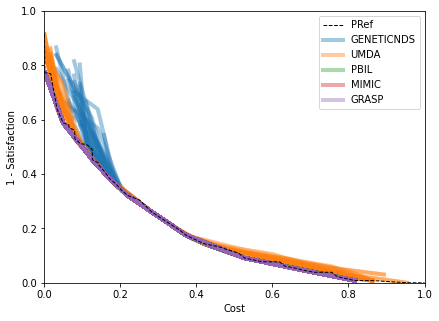

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticnds,0.9557,0.1845,0.6401,257.3705,10.0000
1,umda,0.9792,0.1868,0.5988,446.9136,10.0000
2,pbil,0.9917,0.2326,0.5191,170.2203,10.0000
3,mimic,0.9931,0.2326,0.5190,525.8765,10.0000
4,GRASP,0.9931,0.2326,0.5190,903.7309,10.0000


---------------------------------------------------------------
p2
Pareto Reference has 286 points
Maximum UNFR possible is 10/286=0.0350


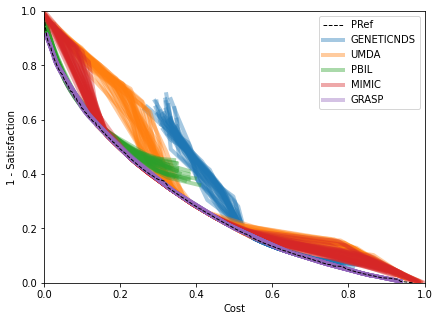

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticnds,0.7109,0.0099,0.7277,348.6996,10.0000
1,umda,0.8129,0.0090,0.6239,1055.5676,10.0000
2,pbil,0.6815,0.0041,0.5865,143.0020,10.0000
3,mimic,0.8532,0.0152,0.6348,2621.3884,10.0000
4,GRASP,0.8884,0.0267,0.6374,9082.5235,10.0000


---------------------------------------------------------------
s1
Pareto Reference has 132 points
Maximum UNFR possible is 10/132=0.0758


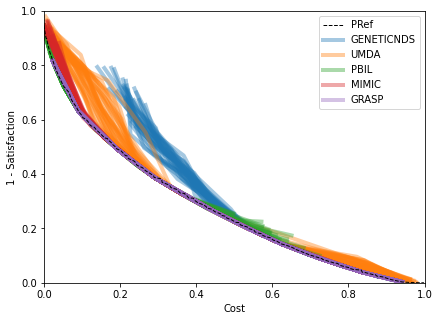

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticnds,0.7757,0.0313,0.6583,319.0598,10.0000
1,umda,0.8516,0.0389,0.5843,824.6743,10.0000
2,pbil,0.8356,0.0611,0.5852,178.7874,10.0000
3,mimic,0.8787,0.0604,0.5765,1205.6833,10.0000
4,GRASP,0.8868,0.0753,0.5309,2258.8160,10.0000


---------------------------------------------------------------
s2
Pareto Reference has 349 points
Maximum UNFR possible is 10/349=0.0287


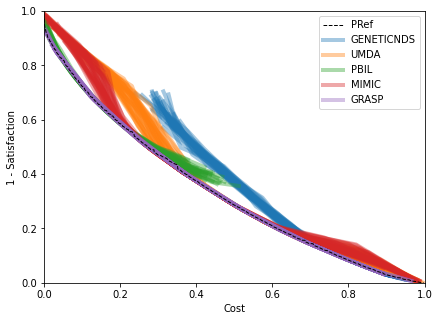

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticnds,0.6803,0.0073,0.6357,265.8247,10.0000
1,umda,0.7748,0.0117,0.6198,1271.4335,10.0000
2,pbil,0.6664,0.0087,0.5756,194.4788,10.0000
3,mimic,0.7933,0.0121,0.5952,2672.4325,10.0000
4,GRASP,0.8202,0.0238,0.6399,6591.5126,10.0000


---------------------------------------------------------------
s3
Pareto Reference has 379 points
Maximum UNFR possible is 10/379=0.0264


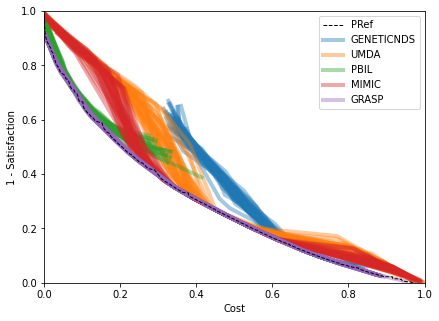

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticnds,0.6793,0.0062,0.7187,397.2759,10.0000
1,umda,0.7837,0.0056,0.6022,1870.1088,10.0000
2,pbil,0.6093,0.0018,0.6165,141.9604,10.0000
3,mimic,0.8173,0.0106,0.5897,3004.2140,10.0000
4,GRASP,0.8711,0.0208,0.6125,16413.3117,10.0000


---------------------------------------------------------------
s4
Pareto Reference has 468 points
Maximum UNFR possible is 10/468=0.0214


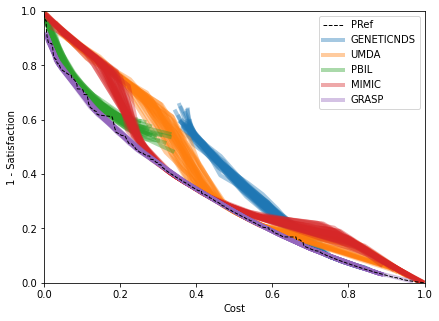

,Method,HV,UNFR,spread,time(s),|NDS|
0,geneticnds,0.6436,0.0040,0.6823,320.8757,10.0000
1,umda,0.7573,0.0031,0.6091,1982.6235,10.0000
2,pbil,0.5472,0.0019,0.5768,151.4819,10.0000
3,mimic,0.7783,0.0045,0.6288,1728.9456,10.0000
4,GRASP,0.8447,0.0129,0.6176,33290.6779,10.0000


---------------------------------------------------------------
Wins Counts:
{'geneticnds': 0, 'umda': 0, 'pbil': 0, 'mimic': 1, 'GRASP': 5}
Wins in datasets:
{'geneticnds': [], 'umda': [], 'pbil': [], 'mimic': ['p1'], 'GRASP': ['p2', 's1', 's2', 's3', 's4']}
Wins Counts UNFR:
{'geneticnds': 0, 'umda': 0, 'pbil': 1, 'mimic': 0, 'GRASP': 5}
Wins Counts Spread:
{'geneticnds': 0, 'umda': 0, 'pbil': 3, 'mimic': 2, 'GRASP': 1}


In [136]:
#alg_copy = [x for x in algorithms]
#algorithms.remove('nsgaii')
plot_algorithms_nds(use_best_global_config=use_best_config_in_all_datasets, sss_per_iteration=True)
#algorithms = alg_copy